In [1]:
#!pip install pandas sklearn numerapi

In [2]:
import numerapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing
import lightgbm
import json
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

napi = numerapi.NumerAPI()

In [3]:
napi.download_dataset("v4/train_int8.parquet", "train_int8.parquet")
napi.download_dataset("v4/validation_int8.parquet", "validation_int8.parquet")
napi.download_dataset("v4/features.json", "features.json")

2022-10-16 20:08:08,649 INFO numerapi.utils: target file already exists
2022-10-16 20:08:08,650 INFO numerapi.utils: download complete
2022-10-16 20:08:10,268 INFO numerapi.utils: target file already exists
2022-10-16 20:08:10,269 INFO numerapi.utils: download complete
2022-10-16 20:08:12,333 INFO numerapi.utils: target file already exists
2022-10-16 20:08:12,334 INFO numerapi.utils: download complete


In [4]:
with open("features.json", "r") as f:
    feature_metadata = json.load(f)
features = feature_metadata['feature_sets']['small']

In [5]:
train_df = pd.read_parquet('train_int8.parquet', columns=['id', 'era', 'target']+features).reset_index()
evaluation_df = pd.read_parquet('validation_int8.parquet', columns=['id', 'era', 'target']+features).reset_index()

train_df.loc[:, "era"] = train_df.era.astype(int)
evaluation_df.loc[:, "era"] = evaluation_df.era.astype(int)

In [6]:
validation_df = evaluation_df.loc[lambda x: (x.era > 600) & (x.era <= 800)].reset_index(drop=True)
test_df = evaluation_df.loc[lambda x: (x.era > 800) & (x.era <= 1000)].reset_index(drop=True)

## Train models on train set

In [7]:
model_library = {'ridge': Ridge(), 
                 'randomforest100': RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1),
                 'randomforest300': RandomForestRegressor(n_estimators=300, max_depth=5, n_jobs=-1),
                 'sgd': SGDRegressor(),
                 'boosting100': lightgbm.LGBMRegressor(n_estimators=100, max_depth=5, n_jobs=-1), 
                 'boosting300': lightgbm.LGBMRegressor(n_estimators=300, max_depth=5, n_jobs=-1), 
                 'neuralnet': MLPRegressor()}

train_data_library = {i: (train_df.loc[lambda x: (x.era%4) == i]) for i in range(4)}

In [8]:
#%%time
model_predictions = {}
counter = 0
for model_name, model_obj in model_library.items():
    for era, train_subset_df in train_data_library.items():
        model_obj.fit(train_subset_df.loc[:, features], train_subset_df.target)
        pred_hillclimb = model_obj.predict(validation_df.loc[:, features])
        validation_df.loc[:, 'pred_{}_{}'.format(model_name, era)] = pred_hillclimb
        pred_test = model_obj.predict(test_df.loc[:, features])
        test_df.loc[:, 'pred_{}_{}'.format(model_name, era)] = pred_test
        counter += 1
        print('Completed: {}'.format(counter))

Completed: 1
Completed: 2
Completed: 3
Completed: 4
Completed: 5
Completed: 6
Completed: 7
Completed: 8
Completed: 9
Completed: 10
Completed: 11
Completed: 12
Completed: 13
Completed: 14
Completed: 15
Completed: 16
Completed: 17
Completed: 18
Completed: 19
Completed: 20
Completed: 21
Completed: 22
Completed: 23
Completed: 24
Completed: 25
Completed: 26
Completed: 27
Completed: 28


In [9]:
pred_cols = [c for c in validation_df.columns if (c.startswith('pred'))]
(pred_cols)

['pred_ridge_0',
 'pred_ridge_1',
 'pred_ridge_2',
 'pred_ridge_3',
 'pred_randomforest100_0',
 'pred_randomforest100_1',
 'pred_randomforest100_2',
 'pred_randomforest100_3',
 'pred_randomforest300_0',
 'pred_randomforest300_1',
 'pred_randomforest300_2',
 'pred_randomforest300_3',
 'pred_sgd_0',
 'pred_sgd_1',
 'pred_sgd_2',
 'pred_sgd_3',
 'pred_boosting100_0',
 'pred_boosting100_1',
 'pred_boosting100_2',
 'pred_boosting100_3',
 'pred_boosting300_0',
 'pred_boosting300_1',
 'pred_boosting300_2',
 'pred_boosting300_3',
 'pred_neuralnet_0',
 'pred_neuralnet_1',
 'pred_neuralnet_2',
 'pred_neuralnet_3']

## Validation performance of individual predictions

In [10]:
## Print Correlation performance of each prediction
validation_perf_dict = {}
for pred in pred_cols:
    corr_mean_across_eras = validation_df.groupby('era').apply(lambda df: df[pred].corr(df['target'], method='spearman')).mean()
    validation_perf_dict[pred] = corr_mean_across_eras

validation_perf_df = pd.DataFrame.from_dict(validation_perf_dict, orient='index', columns=['corr_w_target'])
validation_perf_df.sort_values(by='corr_w_target', ascending=False)

,corr_w_target
pred_boosting300_2,0.023665
pred_boosting300_0,0.023088
pred_boosting300_3,0.022943
pred_boosting100_0,0.022816
pred_boosting100_3,0.022517
pred_boosting100_2,0.022328
pred_boosting100_1,0.021768
pred_boosting300_1,0.021441
pred_neuralnet_1,0.020453
pred_neuralnet_3,0.019561


## Ensemble by Forward Selection

In [21]:
%%time
max_num_preds_in_ensemble = 12
best_score_global = -100
added_preds_list = []
for i in range(max_num_preds_in_ensemble):
    best_performer = (-100, '')
    if len(added_preds_list) == 0:
        curr_ensemble_sum = pd.Series([0]*len(validation_df), dtype='float')
    else:
        curr_ensemble_sum = validation_df.loc[:, added_preds_list].sum(axis=1)
    for pred_col in pred_cols:
        extended_ensemble_sum = curr_ensemble_sum + validation_df.loc[:, pred_col]
        extended_ensemble_avg = extended_ensemble_sum / (len(added_preds_list)+1.0)
        validation_df.loc[:, 'ensemble'] = extended_ensemble_avg
        corr_mean_across_eras = validation_df.groupby('era').apply(lambda df: df['ensemble'].corr(df['target'], method='spearman')).mean()
        if corr_mean_across_eras > best_performer[0]:
            best_performer = (corr_mean_across_eras, pred_col)
    print("ensemble_score: {}, added_col: {}".format(best_performer[0], 
                                                    best_performer[1]))
    if best_performer[0] > (best_score_global - 1e-6):
        best_score_global = best_performer[0]
    else:
        break
    added_preds_list.append(best_performer[1])

ensemble_score: 0.023664808137005697, added_col: pred_boosting300_2
ensemble_score: 0.024952460487018838, added_col: pred_boosting300_0
ensemble_score: 0.025177584118833057, added_col: pred_boosting300_3
ensemble_score: 0.025559504634132226, added_col: pred_sgd_0
ensemble_score: 0.02581686338766487, added_col: pred_boosting300_2
ensemble_score: 0.02585506955990696, added_col: pred_boosting300_0
ensemble_score: 0.025868786177456204, added_col: pred_boosting300_2
ensemble_score: 0.025893105846187706, added_col: pred_sgd_2
ensemble_score: 0.02591868092725079, added_col: pred_boosting300_3
ensemble_score: 0.025931658541080677, added_col: pred_boosting300_2
ensemble_score: 0.0259476288957518, added_col: pred_boosting300_0
ensemble_score: 0.025971243820355504, added_col: pred_neuralnet_1
CPU times: user 2min 9s, sys: 22.5 s, total: 2min 31s
Wall time: 2min 32s


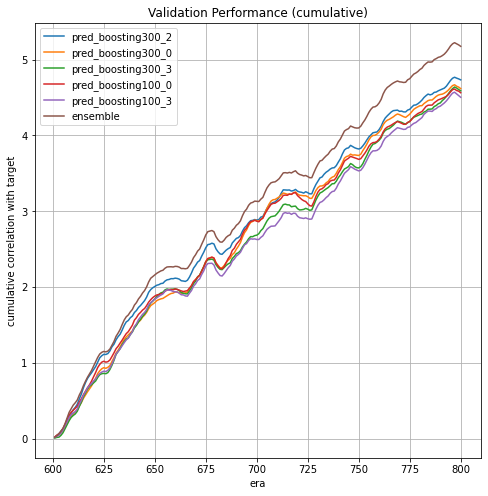

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

best_individual_preds = validation_perf_df.sort_values(by='corr_w_target', ascending=False).iloc[:5].index

for pred in best_individual_preds:
    corr_perf = validation_df.groupby('era').apply(lambda df: df[pred].corr(df['target'], method='spearman'))
    ax.plot(corr_perf.cumsum(), label = pred)

ensemble_perf = validation_df.groupby('era').apply(lambda df: df['ensemble'].corr(df['target'], method='spearman'))
ax.plot(ensemble_perf.cumsum(), label='ensemble')
ax.set_title('Validation Performance (cumulative)')
ax.set_xlabel('era')
ax.set_ylabel('cumulative correlation with target')
ax.legend()
ax.grid()

#### Observation: Ensemble performance is better than any of the individual predictions

In [23]:
# Weights of predictions in final ensemble
ensemble_weights_dict = Counter()
ensemble_weights_dict.update(added_preds_list)
ensemble_weights_dict

Counter({'pred_boosting300_2': 4,
         'pred_boosting300_0': 3,
         'pred_boosting300_3': 2,
         'pred_sgd_0': 1,
         'pred_sgd_2': 1,
         'pred_neuralnet_1': 1})

## Test Performance of individual predictions

In [24]:
## Print Correlation performance of each prediction
test_perf_dict = {}
for pred in pred_cols:
    corr_mean_across_eras = test_df.groupby('era').apply(lambda df: df[pred].corr(df['target'], method='spearman')).mean()
    test_perf_dict[pred] = corr_mean_across_eras

test_perf_df = pd.DataFrame.from_dict(test_perf_dict, orient='index', columns=['corr_w_target'])
test_perf_df.sort_values(by='corr_w_target', ascending=False)

,corr_w_target
pred_boosting300_2,0.015229
pred_boosting300_3,0.015083
pred_boosting100_1,0.015076
pred_boosting100_2,0.014957
pred_boosting300_1,0.014944
pred_boosting100_3,0.014837
pred_boosting100_0,0.014705
pred_boosting300_0,0.014188
pred_neuralnet_3,0.013233
pred_neuralnet_1,0.012885


## Ensemble Performance on Test df

In [25]:
test_ensemble_sum = pd.Series([0]*len(test_df), dtype='float')
for pred in pred_cols:
    if pred not in ensemble_weights_dict.keys():
        continue
    test_ensemble_sum += (test_df.loc[:, pred] * ensemble_weights_dict[pred])

test_ensemble_avg = test_ensemble_sum / sum(ensemble_weights_dict.values())
test_df.loc[:, 'ensemble'] = test_ensemble_avg

In [27]:
test_corr_ensemble = test_df.groupby('era').apply(lambda df: df['ensemble'].corr(df['target'], method='spearman'))
test_corr_ensemble.mean()

0.015904463019279554

## Comparison of Ensemble Performance with Individual predictions

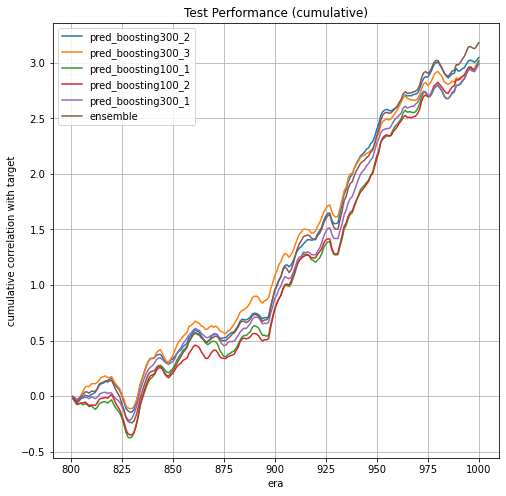

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

best_individual_preds = test_perf_df.sort_values(by='corr_w_target', ascending=False).iloc[:5].index

for pred in best_individual_preds:
    corr_perf = test_df.groupby('era').apply(lambda df: df[pred].corr(df['target'], method='spearman'))
    ax.plot(corr_perf.cumsum(), label = pred)

ensemble_perf = test_df.groupby('era').apply(lambda df: df['ensemble'].corr(df['target'], method='spearman'))
ax.plot(ensemble_perf.cumsum(), label='ensemble')
ax.set_title('Test Performance (cumulative)')
ax.set_xlabel('era')
ax.set_ylabel('cumulative correlation with target')
ax.legend()
ax.grid()